In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install mlflow
! pip install pyngrok
! pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
# Cấu hình MLflow để lưu trữ kết quả vào Google Drive
import mlflow
mlflow.set_tracking_uri('/content/drive/MyDrive/MLOPs/mlruns')

In [ ]:
import os
import shutil
import pprint
from random import random, randint
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifacts
from sklearn.ensemble import RandomForestRegressor
from mlflow.tracking import MlflowClient
import warnings

In [ ]:
# Set the tracking server to be localhost with sqlite as tracking store
local_registry = "sqlite:///mlruns.db"
print(f"Running local model registry={local_registry}")
model_name="WeatherForecastModel"
mlflow.set_tracking_uri(local_registry)
with mlflow.start_run(run_name="LOCAL_REGISTRY") as run:
    params = {"n_estimators": 3, "random_state": 0}
    sk_learn_rfr = RandomForestRegressor(params)

    # Log parameters and metrics using the MLflow API
    mlflow.log_params(params)
    log_param("param_1", randint(0, 100))
    log_metric("metric_1", random())
    log_metric("metric_2", random() + 1)
    log_metric("metric_33", random() + 2)

    # Log and register the model at the same time
    mlflow.sklearn.log_model(
                sk_model = sk_learn_rfr,
                artifact_path = "sklearn-model",
                registered_model_name="WeatherForecastModel")
    if not os.path.exists("outputs"):
        os.makedirs("outputs")
    with open("outputs/test.txt", "w") as f:
        f.write("Looks, like I logged to the local store!")
    log_artifacts("outputs")
    shutil.rmtree('outputs')
    run_id = run.info.run_uuid

Running local model registry=sqlite:///mlruns.db


2024/12/24 05:25:44 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/12/24 05:25:44 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [ ]:
client = MlflowClient()
#
# transition model stage to production
#
client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="production")

# Get a list of all registered models
print("List of all registered models")
print("=" * 80)
# [print(pprint.pprint(dict(rm), indent=4)) for rm in client.list_registered_models()]
models = client.search_registered_models()
for model in models:
    print(model)
# Get a list of specific versions of the named models
print(f"List of Model = {model_name} and Versions")
print("=" * 80)
[pprint.pprint(dict(mv), indent=4) for mv in client.search_model_versions("name='WeatherForecastModel'")]


In [ ]:
get_ipython().system_raw("mlflow ui --backend-store-uri sqlite:///mlruns.db --port 5000 &")# run tracking UI in the background

In [ ]:
# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6
!pip install pyngrok --quiet
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2qYZXnYuknPPYl92p1UdAe9dz7M_3fKEgnQJbdyEGGwnjP3mm"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
public_url = ngrok.connect(port="5000", proto="http", options={"bind_tls": True})
print("MLflow Tracking UI:", public_url)

WARNI [pyngrok.process.ngrok] t=2024-12-24T05:27:27+0000 lvl=warn msg="invalid tunnel configuration" pg=/api/tunnels id=f8e454236594d70f err="yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel\n  line 1: field options not found in type config.HTTPv2Tunnel"


PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel\n  line 1: field options not found in type config.HTTPv2Tunnel"}}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch

# Load pre-trained VGG16 model
model = torchvision.models.vgg16(pretrained=True)

# Replace the classifier for fine-tuning (optional)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)  # assuming 10 classes for the output

# Move model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare the dataset and data loader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tải bộ dữ liệu CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/MLOPs/data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/MLOPs/data',
    train=False,
    download=True,
    transform=transform
)

# Hàm lọc dữ liệu chỉ lấy 3 lớp đầu tiên (0: Máy bay, 1: Xe hơi, 2: Chim)
def filter_classes(dataset, classes=[0, 1, 2]):
    indices = [i for i, label in enumerate(dataset.targets) if label in classes]
    return Subset(dataset, indices)

# Lọc dữ liệu chỉ lấy 3 lớp đầu tiên
filtered_train_dataset = filter_classes(train_dataset)
filtered_test_dataset = filter_classes(test_dataset)

train_size = int(0.8 * len(filtered_train_dataset))  # 80% dữ liệu cho training
val_size = len(filtered_train_dataset) - train_size  # 20% dữ liệu cho validation

train_subset, val_subset = random_split(filtered_train_dataset, [train_size, val_size])

# Tạo DataLoader cho từng tập
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(filtered_test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_loss_values = []
    val_loss_values = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        train_loss_values.append(avg_loss)
        val_loss_values.append(avg_val_loss)
        # Log metrics and parameters to MLflow
        mlflow.log_metric('train_loss', avg_loss, step=epoch)
        mlflow.log_metric('train_accuracy', accuracy, step=epoch)
        mlflow.log_metric('val_loss', avg_val_loss, step=epoch)
        mlflow.log_metric('val_accuracy', val_accuracy, step=epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    return train_loss_values, val_loss_values


MLflow UI is live at: NgrokTunnel: "https://d5f8-35-240-184-139.ngrok-free.app" -> "http://localhost:5000"
Epoch [1/10], Train Loss: 0.3985, Train Accuracy: 84.18%, Val Loss: 0.3568, Val Accuracy: 86.00%
Epoch [2/10], Train Loss: 0.3419, Train Accuracy: 87.23%, Val Loss: 0.3215, Val Accuracy: 86.80%
Epoch [3/10], Train Loss: 0.2956, Train Accuracy: 88.36%, Val Loss: 0.3003, Val Accuracy: 88.23%
Epoch [4/10], Train Loss: 0.2524, Train Accuracy: 90.27%, Val Loss: 0.3089, Val Accuracy: 87.80%
Epoch [5/10], Train Loss: 0.2291, Train Accuracy: 91.22%, Val Loss: 0.2667, Val Accuracy: 89.43%
Epoch [6/10], Train Loss: 0.2029, Train Accuracy: 92.35%, Val Loss: 0.2634, Val Accuracy: 90.07%
Epoch [7/10], Train Loss: 0.1790, Train Accuracy: 92.86%, Val Loss: 0.2815, Val Accuracy: 90.03%
Epoch [8/10], Train Loss: 0.1719, Train Accuracy: 93.56%, Val Loss: 0.2927, Val Accuracy: 89.67%
Epoch [9/10], Train Loss: 0.1415, Train Accuracy: 94.57%, Val Loss: 0.3562, Val Accuracy: 88.97%
Epoch [10/10], Train

2024/12/22 11:13:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/22 11:13:07 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/22 11:13:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


(None, None)

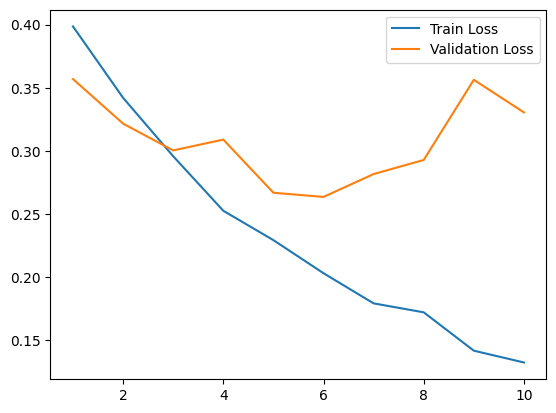

In [ ]:
from pyngrok import ngrok
import threading

ngrok.set_auth_token("2qYZXnYuknPPYl92p1UdAe9dz7M_3fKEgnQJbdyEGGwnjP3mm")
import subprocess

def start_mlflow_ui():
    public_url = ngrok.connect(5000)
    print(f"MLflow UI is live at: {public_url}")
    mlflow_ui_process = subprocess.Popen(["mlflow", "ui", "--port", "5000"])
    mlflow_ui_process.communicate()  # Đảm bảo UI không dừng sớm

ui_thread = threading.Thread(target=start_mlflow_ui)
ui_thread.start()

with mlflow.start_run():
    mlflow.log_param('batch_size', 64)
    mlflow.log_param('epochs', 10)
    mlflow.log_param('learning_rate', 0.001)

    # Train the model and log the results
    train_loss_values, val_loss_values = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    # Log the trained model to MLflow
    mlflow.pytorch.log_model(model, "vgg16_model")
    epochs = range(1, 11)
    # Example: Save and log the loss curve (optional)
    plt.plot(epochs, train_loss_values, label="Train Loss")
    plt.plot(epochs, val_loss_values, label="Validation Loss")
    plt.legend()
    plt.savefig("loss_curve.png")
    mlflow.log_artifact("loss_curve.png")
    plt.savefig("local_loss_curve.png")
ui_thread.join()